https://kaggle-kr.tistory.com/32<br>
https://kaggle-kr.tistory.com/18?category=868316

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib의 기본 scheme 말고 seaborn scheme을 세팅하고, 일일이 graph의 font size를 지정할 필요 없이 seaborn의 font_scale을 사용하면 편합니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5)

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv('titanic/train.csv')
df_test = pd.read_csv('titanic/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1  # 자신을 포함해야하니 1을 더합니다.
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1  # 자신을 포함해야하니 1을 더합니다.

# null값을 평균값으로 대체
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

In [2]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,2.893846,1.904602
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,1.002899,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,2.068177,1.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,2.670985,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,3.433987,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,6.238967,11.000000


In [3]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize
count,418.000000,418.000000,332.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,2.947868,1.839713
std,120.810458,0.841838,14.181209,0.896760,0.981429,1.006656,1.519072
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,2.066331,1.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,2.670985,1.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,3.449988,2.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,6.238967,11.000000


# 3. Feature Engineering

* 가장 먼저 dataset에 존재하는 null data를 채우려고 합니다.
* 아무 숫자로 채울 수는 없고, null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
* null data를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야 할 부분입니다.
* Feature Engineering은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만 아니라 test도 똑같이 적용해주어야 합니다.

## 3.1. Fill Null

## 3.1.1. Fill Null in Age using title

* Age에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics를 사용해 보겠습니다.
* 영어에서는 Miss, Mrr, Mrs같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게 되는데 이를 사용해보겠습니다.
* pandas series에는 data를 string으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 initial column에 저장하겠습니다.

In [4]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

* pandas의 crosstab을 이용하여 우리가 추출한 initial과 Sex간의 count를 살펴봅시다.

In [5]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')  # Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


* 위 table을 참고하여 남자, 여자가 쓰는 initial을 구분해보겠습니다. replace 메서드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.

In [6]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [7]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


* 여성과 관계 있는 Miss, Mrs가 생존률이 높은 것을 볼 수 있습니다.

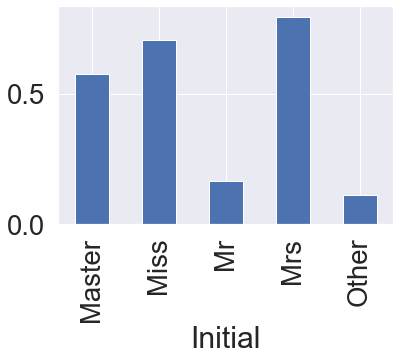

In [8]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [9]:
df_train.groupby('Initial')['Survived'].mean()

Initial
Master    0.575000
Miss      0.704301
Mr        0.162571
Mrs       0.795276
Other     0.111111
Name: Survived, dtype: float64

* 이제 본격적으로 Null을 채울 것입니다. null data를 채우는 방법은 정말 많이 존재합니다. statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워 넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다.
* 여기서 statistics는 train data의 것을 의미합니다. 우리는 언제나 test를 unseen으로 둔 상태로 놔둬야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워줘야 합니다.

In [10]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


* Age의 평균을 이용해 Null value를 채우도록 하겠습니다.
* pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 편리합니다.
* 아래 코드 첫 줄을 해석하자면, isnull()이면서 initial이 Mr인 조건을 만족하는 row(탑승객)의 'Age' 의 값을 33으로 치환한다 입니다.

In [11]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

## 3.1.2. Fill Null in Embarked

In [12]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


* Embarked는 Null value가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채우겠습니다.
* dataframe의 fillna method를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True로 하면 df_train에 fillna를 실제로 적용하게 됩니다.

In [13]:
df_train['Embarked'].fillna('S', inplace=True)

# loc을 이용한 방법
# df_train.loc[df_train.Embarked.isnull(), 'Embarked'] = 'S'

## 3.2. Change Age(continuous to categorical)

* Age는 현재 continuous feature입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇 개의 group으로 나누어 category화 시켜줄 수 도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수도 있습니다.
* 방법은 여러가지가 있습니다. dataframe의 indexing 방법인 loc을 사용하여 직접해 줄 수 있고, apply를 사용해 함수를 넣어줄 수 있습니다.

* 첫 번째로 loc을 사용한 방법입니다. 나이는 10살 간격으로 나눕니다.

In [14]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

* 두 번째로 간단한 함수를 만들어 apply 메서드에 넣어주는 방법입니다.

In [15]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

* 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.
* 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [16]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


* 이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age 를 제거하겠습니다.

In [17]:
# 특정 column 삭제

df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3. Change Initial, Embarked and Sex (string to numerical)

* 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
* map method 를 가지고 간단히 할 수 있습니다.
* 사전 순서대로 정리하여 mapping 하겠습니다

In [18]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

* Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.
* 그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [19]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [20]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [21]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

* 한번 Null 이 사라졌는지 확인해봅시다. Embarked Column만 가져온 것은 하나의 pandas의 Series 객체므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다.

In [22]:
df_train['Embarked'].isnull().any()

False

In [23]:
df_train.isnull()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Initial,Age_cat
0,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,True,False,False,False,False
887,False,False,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,False,False,False,False,True,False,False,False,False
889,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [24]:
df_train['Embarked'].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Name: Embarked, Length: 891, dtype: bool

* Sex 도 Female, male 로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

In [25]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

* 이제 각 feature 간의 상관관계를 한번 보려고 합니다. 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다.
* 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

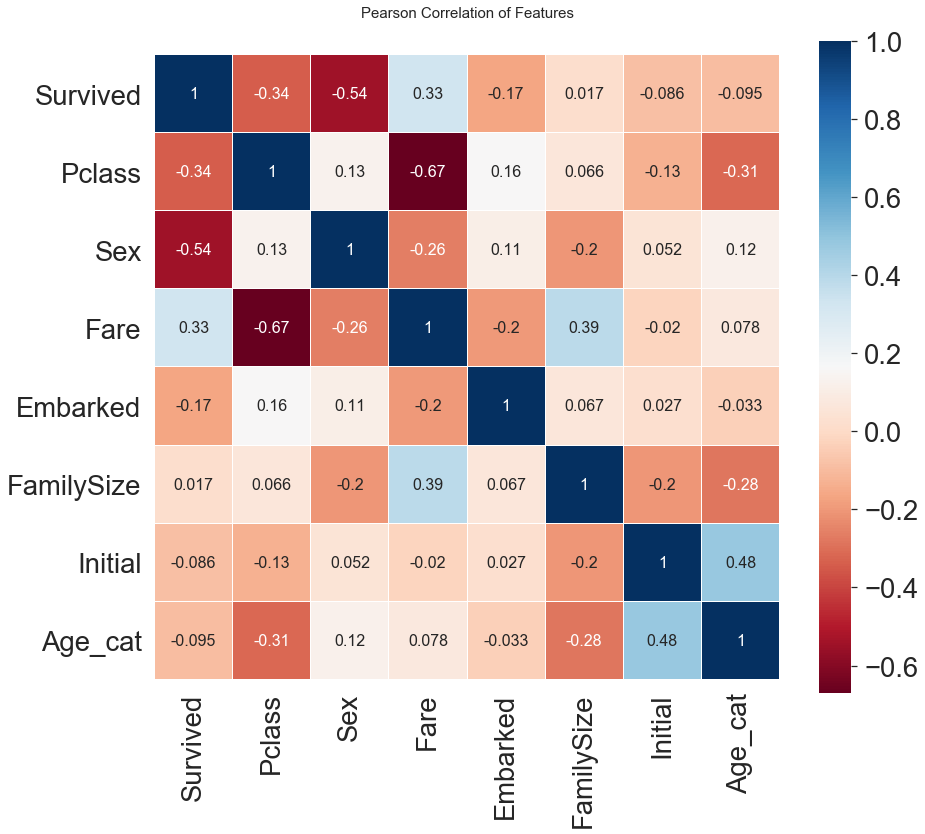

In [26]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

* 우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.
* 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
* 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
* 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.

*Check*<br>
<br>
노인/여성/어린이의 생존률이 높다고 알려져 있기 때문에, Survived와 Age_cat의 상관관계가 높다고 생각할 수 있다. 하지만 Age가 증가할수록 Survived가 증가하는 형태가 아니라, 어린이와 노인(양 끝)의 Survived가 높은 형태이기 때문에 Survived와 Age_cat(Age)는 증가 또는 감소 경향이 아니다. 따라서 상관관계가 높지 않다.

## 3.4. One-hot Encoding on Initial and Embarked

* 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.
* 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다.
* One-hot encoding 은 위 카테고리를 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.
* 이러한 작업을 직접 코딩할 수도 있지만, pandas 의 get_dummies 를 사용하여 쉽게 해결 할 수 있습니다.
* 총 5개의 카테고리니, one-hot encoding 을 하고 나면 새로운 5개의 column 이 생겨납니다.
* Initial 을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [27]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [28]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


* 보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns 가 생성된 것이 보입니다
* Embarked 에도 적용하겠습니다. Initial 때와 마찬가지로 one-hot encoding 을 사용해 표현하겠습니다.

In [29]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

* 아주 쉽게 one-hot encoding 을 적용했습니다.
* sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능합니다.
* 가끔 category 가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

## 3.5. Drop columns

In [30]:
# columns 삭제

df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [31]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [32]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


보시다시피, train 의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns 를 가진 걸 확인할 수 있습니다.

# 4. Building machine learning model and prediction using the trained model

In [33]:
# importing all the required ML packages

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

* 지금 타이타닉 문제는 target class(survived)가 있으며, target class는 0, 1로 이루어져 있으므로(binary) binary classification 문제입니다.
* 우리가 지금 가지고 있는 train set의 survived를 제외한 input을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존 유무를 판단하는 모델을 만들어냅니다.
* 그 후 모델이 학습하지 않았던 test set을 input으로 주어서 test set의 각 샘플(탑승객)의 생존 유무를 예측해봅니다.

## 4.1. Preparation - Split dataset into train, valid, test set

* 가장 먼저 학습에 쓰일 데이터와 target label(Survived)를 분리합니다.

In [34]:
# 특정 column 삭제

X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

* 보통 train, test만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델을 평가해봅니다.
* 마치 축구대표팀이 팀 훈련(train)을 하고 바로 월드컵(test)으로 나가는 것이 아니라, 팀 훈련(train)을 한 다음 평가전(valid)를 거쳐 팀의 훈련 정도(학습 정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.
* train_test_split을 사용하여 쉽게 train set을 분리할 수 있습니다.

In [35]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2022)

* random forest는 decision tree 기반 모델이며, 여러 decision tree들을 ensemble한 모델입니다.
* 각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. random forest 분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.
* 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 결국 많이 써봐야 모델도 잘 세울 수 있는 것이죠.
* 모델을 만들고, fit 메서드로 학습시킵니다. 그런 다음 valid set input을 넣어 주어 예측값(X_vld sample(탑승객)의 생존 여부)를 얻습니다.

## 4.2. Model generation and prediction

In [36]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [37]:
prediction

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [38]:
y_vld

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1], dtype=int64)

In [39]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100*metrics.accuracy_score(prediction, y_vld)))

총 268명 중 79.10% 정확도로 생존을 맞춤


## 4.3. Feature importance

* 학습된 모델은 feature importance를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature에 영향을 많이 받았는지 확인할 수 있습니다.
* 학습된 모델은 기본적으로 feature importances를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.
* pandas series를 이용하면 쉽게 sorting을 하여 그래프를 그릴 수 있습니다.

In [40]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

In [41]:
feature_importance

array([0.0917696 , 0.13000074, 0.31147399, 0.1012712 , 0.1071949 ,
       0.01707229, 0.02589792, 0.14294656, 0.02737974, 0.00675199,
       0.01321025, 0.01062636, 0.01440448])

In [42]:
df_test.columns

Index(['Pclass', 'Sex', 'Fare', 'FamilySize', 'Age_cat', 'Initial_0',
       'Initial_1', 'Initial_2', 'Initial_3', 'Initial_4', 'Embarked_0',
       'Embarked_1', 'Embarked_2'],
      dtype='object')

In [43]:
Series_feat_imp

Pclass        0.091770
Sex           0.130001
Fare          0.311474
FamilySize    0.101271
Age_cat       0.107195
Initial_0     0.017072
Initial_1     0.025898
Initial_2     0.142947
Initial_3     0.027380
Initial_4     0.006752
Embarked_0    0.013210
Embarked_1    0.010626
Embarked_2    0.014404
dtype: float64

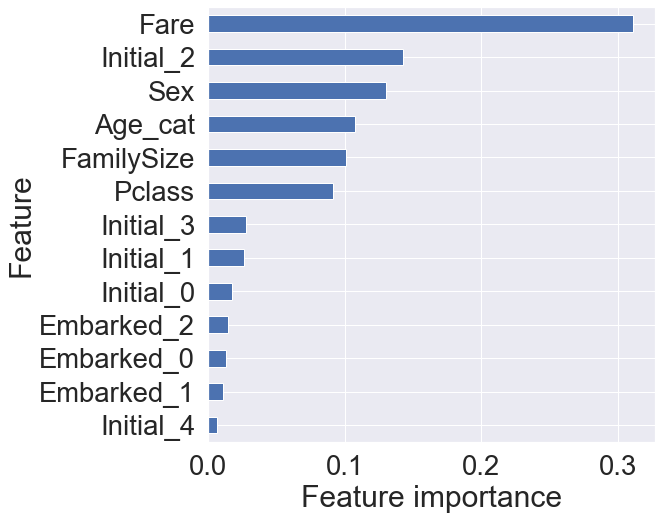

In [44]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

* 우리가 얻은 모델에서는 Fare가 가장 큰 영향력을 가지며, 그 뒤로 initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다.
* 사실 feature importance는 지금 모델에서의 importance를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance가 다르게 나올 수 있습니다.
* 이 feature importnace를 보고 실제로 Fare가 중요한 feature일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 더 살펴보긴 해야 합니다.
* feature importance를 가지고 좀 더 정호악도가 높은 모델을 얻기 위해 feature selection을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수도 있습니다.

## 4.4. Prediction on Test Set

In [45]:
submission = pd.read_csv('titanic/gender_submission.csv')

In [46]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [47]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [48]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [49]:
submission.to_csv('titanic/my_first_submission.csv', index=False)